# Experiments on the grid map

In [1]:
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy

import sys
sys.path.append('../')

from MAPF import SpaceTimeAStar, MultiAgentAStar, CBS, PBS
from MAPF.HighLevelSearch import SearchNodeContainer, ConstraintTree

%load_ext autoreload
%autoreload 2

%matplotlib inline


In [2]:
n_nodes = 400
# n_nodes = 16
obstacle_ratio = 0.1


ldim = int(np.ceil(np.sqrt(n_nodes)))
udim = int(np.floor(np.sqrt(n_nodes)))

G = nx.grid_graph([ldim,udim])
G = nx.convert_node_labels_to_integers(G)
for i in G: # Add self-loops to allow the agent staying at the node.
    G.add_edge(i,i)


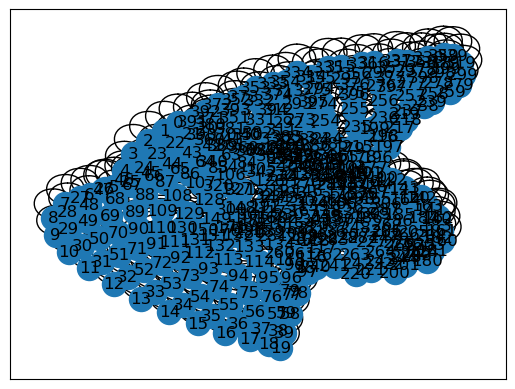

In [3]:
nx.draw_networkx(G)

In [4]:
from tqdm import trange
from functools import partial

In [17]:
from MAPF.metrics import flowtime, makespan
from MAPF.conflict import find_conflict
def BackwardInvariantCBS(G, start_nodes,goal_nodes, edge_weights = None, \
                         max_iter = 2000, metric = 'flowtime',\
                         check_edge_conflicts = False, search_type = 'best_first'):


    if metric == 'flowtime':
        metric = flowtime
    elif metric == 'makespan':
        metric = makespan
    else:
        print('Metric {} is not supported. Please input "flowtime" or "makespan".'.format(metric))

    if edge_weights is None:
        edge_weights = {e:1 for e in G.edges} # Assume uniform weights if None is given.
        edge_weights.update({e[::-1]:1 for e in G.edges})

    nx.set_edge_attributes(G,edge_weights,'weight')

    hScore = dict(nx.shortest_path_length(G,weight = 'weight')) # The heuristic score used in SpaceTimeAStar

    # Initialization: 
    # Plan inidivual paths for agent agent without considering conflicts.
    # We simply call the standard networkx library.
    p = nx.shortest_path(G,weight = 'weight') # The [weight] argument here should be the key to weight values in the edge data dictionary.
    plan0 = [p[s][g] for s, g in zip(start_nodes, goal_nodes)]

    CT = ConstraintTree()
    ROOT = CT.add_node(None,plan0,metric(G,plan0,goal_nodes),[]) # Adding the root node. 

    OPEN = SearchNodeContainer()
    OPEN.push(CT.get_cost(ROOT),ROOT) 

    count = 0
    while not OPEN.empty() and count<=max_iter:
        count+=1 
        # CBS does not have a way to determine infeasibility. 
        # To avoid infinite loops, we stop it when it exceeded an iteration threshold..
        cost, parent_node = OPEN.pop()
        solution = CT.get_solution(parent_node)

        # Look for the first conflict.
        conflict = find_conflict(solution,check_edge_conflicts)

        # print(OPEN.queue, conflict,solution)
        if not conflict:
            # print('Solution found', solution, cost)
            # break
            
            print('Total iterations = ',count,'OPEN empty?',OPEN.empty()) 
            return solution, cost
        else:

            a1, a2, c, t = conflict # c could either be a node or an edge.
            print('conflict',conflict,'t',t)
            
            

            if type(c) is int:
                t0 = t-1
            elif type(c) is tuple:
                t0 = t

            for a,ap in [(a1,a2),(a2,a1)]: # Create two children of the current CT node.
                if t>=len(solution[a])-1:
                    continue 
                    # If the conflict happens because ap hit a after a has reached its goal node, we deem ap should yield to a.
                    # An agent that has reached its node should have higher priority.
                    
                # Construct the constraint set
                other_agent_pos = set()
                other_traversed_edges = set()
                for i in range(len(solution)):
                    if i!=a:
                        next_t = min(t0+1,len(solution[i])-1)
                        other_agent_pos.add(solution[i][next_t])
                        other_traversed_edges.add(tuple(solution[i][next_t-1:next_t+1]))

                # print('other agent pos',other_agent_pos)
                # Construct the constraint set for the agent.
                node_constraints = {s:set() for s in G}            
                for s in other_agent_pos:
                    node_constraints[s].add(1)

                edge_constraints = {e:set() for e in G.edges}
                edge_constraints.update({e[::-1]:set() for e in G.edges})

                for e in other_traversed_edges: 
                    if len(e)>1:# Ignore the traverses which stay at the same node.
                        edge_constraints[e].add(0)
                
                permanent_obstacles = {}
                
                if type(c) is int:
                    if t>=len(solution[ap])-1: # The conflict happens because a crashes into ap in ap's goal node.
                        # print('permanent crash')
                        permanent_obstacles[c] = 1
                        # print('permanet_obstacles',permanent_obstacles)    
                    else:
                        node_constraints[c].add(1)
                elif type(c) is tuple:
                    edge_constraints[c].add(0)
                    edge_constraints[c[::-1]].add(0)


                # print('agent',a,'node constraints',node_constraints,'c',c)
                # print('solution[a]', solution[a],'t0',t0)
                
                
                # Call Space-time A* algorithm to partially replan the agent's path.
                curr_t = min(t0,len(solution[a])-2) 
                # If the conflict happens because a is hit by ap after a reaches its goal node, then we must set the start node to be one-step before the goal.
                
                result = SpaceTimeAStar(G, start=solution[a][curr_t], goal=goal_nodes[a]\
                                        ,node_constraints=node_constraints,edge_constraints=edge_constraints,\
                                        permanent_obstacles=permanent_obstacles\
                                        , hScore = hScore)

                if result: # If there is a feasible single-agent path. 
                    # print('result',result,'start',solution[a][t-1],'goal',goal_nodes[a],'solution',solution)
                    path, gscore = result
                    new_solution = deepcopy(solution)
                    new_solution[a] = solution[a][:curr_t] + path
                    # if count>=0.98*max_iter:
                    # print('agent',a,'old_solution',solution,'new_solution',new_solution)
                    # print('old_solution[:t]',solution[a][:curr_t])
                    

                    # Create a new child in the Constraint Tree.
                    new_node_ID = CT.add_node(parent_node, new_solution,\
                                                 metric(G,new_solution,goal_nodes),[])
                    # print('parent_node',parent_node,'new node', new_node_ID)
                    # print('agent',ap,'old_solution[a]',solution[ap])
                    # print('agent',a,'old_solution[a]',solution[a],'new_solution[a]',new_solution[a],'path',path)
                   
                    # Push the new child onto the OPEN queue.
                    OPEN.push(CT.get_cost(new_node_ID),new_node_ID)
                # else:
                #     print('No SAPF solution')

    print('Total iterations = ',count,'OPEN empty?',OPEN.empty()) 
    return None


In [18]:
n_agents = 50

# start_nodes = tuple(np.random.choice(range(n_nodes),n_agents,replace=False)) # Must be hashable.

# goal_nodes = tuple(np.random.choice(range(n_nodes),n_agents,replace=False)) 


messages = ['CBS','Backward Invariant CBS', 'PBS: Depth First', 'PBS: Best First']
algs = [
    partial(CBS,max_iter=8000,check_edge_conflicts=True),
        partial(BackwardInvariantCBS,max_iter=200,check_edge_conflicts=True,search_type = 'depth_first'),
        partial(PBS,search_type = 'depth_first'),
        partial(PBS,search_type = 'best_first'),
       ]

for i in [1,2]:
    print(messages[i], algs[i](G,start_nodes,goal_nodes))

conflict [2, 15, 335, 1] t 1
conflict [11, 42, 336, 1] t 1
conflict [2, 15, 315, 2] t 2
conflict [6, 16, 240, 2] t 2
conflict [11, 42, 335, 2] t 2
conflict [45, 47, 356, 2] t 2
conflict [24, 48, 74, 2] t 2
conflict [14, 39, (289, 309), 2] t 2
conflict [6, 10, 260, 3] t 3
conflict [13, 14, 309, 3] t 3
conflict [3, 30, 92, 3] t 3
conflict [11, 42, 334, 3] t 3
conflict [9, 49, 80, 3] t 3
conflict [11, 42, 333, 4] t 4
conflict [29, 45, 335, 4] t 4
conflict [5, 8, (105, 106), 4] t 4
conflict [11, 42, 332, 5] t 5
conflict [29, 45, 334, 5] t 5
conflict [27, 46, 186, 5] t 5
conflict [0, 22, (313, 314), 5] t 5
conflict [26, 44, (193, 194), 5] t 5
conflict [27, 46, (186, 206), 5] t 5
conflict [13, 14, 312, 6] t 6
conflict [12, 26, 194, 6] t 6
conflict [8, 38, 125, 6] t 6
conflict [11, 42, 331, 6] t 6
conflict [17, 43, 210, 6] t 6
conflict [29, 45, 333, 6] t 6
conflict [0, 13, 312, 7] t 7
conflict [12, 24, 174, 7] t 7
conflict [8, 32, 145, 7] t 7
conflict [11, 42, 330, 7] t 7
conflict [29, 45, 33